# Weekly assignment 2: linear regression

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In this assignment, we will use data from Mashable. Mashable is an online magazine that focuses on producing viral content. We're going to predict what makes an article viral by predicting the number of shares. We're actually predicting the logarithm of the number of shares, which is more normally distributed (bell shape) than the actual number of shares.

We're predicting the log of shares with linear regression. Linear regression is a model that assumes linear relations between a Y variable and several X variables. The model follows the general formula:

$ Y = b_0 + b_1X_1 + b_2X_2 + ... + e $

variables:  
$ Y $ = dependent variable (dependent on the X variable)  
$ X_1..X_n $ = independent variables (influences the Y variable)  

coefficients:  
$ b_0 $ = intercept (where the line intercepts with the y-axis)  
$ b_1..b_n $ = slopes of the line for the different X variables (steepness of the line)  

e = error / residual (what’s left over, what we can’t explain)


In [3]:
# import csv file to pandas df
df = pd.read_csv("Assignment 2 - data Mashable.csv")
df.head()

,id,url,n_tokens_title,n_tokens_content,num_imgs,num_videos,average_token_length,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,...,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,title_subjectivity,title_sentiment_polarity,shares,shares_log
0,1,http://mashable.com/2013/10/29/ashton-kutcher-...,10,821,12,0,4.518879,0,0,0,...,0,0,0,0,0.439379,0.082486,0.666667,0.375,2100,3.322219
1,2,http://mashable.com/2014/09/08/mashies-sept-19...,9,489,6,0,5.040900,0,0,0,...,0,0,0,0,0.300454,0.027715,0.000000,0.000,274,2.437751
2,3,http://mashable.com/2013/02/01/hello-kitty-roc...,11,131,0,1,4.877863,0,0,0,...,1,0,0,0,0.575486,0.259120,0.000000,0.000,1500,3.176091
3,4,http://mashable.com/2014/02/06/add-us-on-snapc...,8,556,2,0,4.974820,0,0,1,...,0,0,0,0,0.327220,0.134424,0.000000,0.000,2000,3.301030
4,5,http://mashable.com/2014/01/07/lindsey-vonn-wi...,9,880,18,0,4.928409,0,0,0,...,0,0,0,0,0.507709,0.109256,0.000000,0.000,6000,3.778151


## Selecting variables

By looking at the correlations between *shares_log* and the other variables, we can decide which 5 variables to pick. Note that we could also simply include all the variables. Since it doesn't matter whether variables are positively or negatively correlated, we'll take the absolute value. The absolute value is always positive (e.g., the absolute value of -0.4 is 0.4).

In [7]:
corr = df.corr() #make correlation matrix
corr["shares_log"].abs().sort_values(ascending=False) #take absolute value of correlations with shares_log and sort

shares_log                       1.000000
shares                           0.483322
data_channel_is_world            0.141932
is_weekend                       0.105919
global_subjectivity              0.093021
num_imgs                         0.085575
data_channel_is_socmed           0.085516
data_channel_is_entertainment    0.080967
weekday_is_saturday              0.072644
weekday_is_sunday                0.071864
title_subjectivity               0.055161
global_sentiment_polarity        0.053199
title_sentiment_polarity         0.050216
data_channel_is_tech             0.047729
num_videos                       0.037147
data_channel_is_lifestyle        0.036926
data_channel_is_bus              0.033469
n_tokens_content                 0.032897
weekday_is_wednesday             0.032125
average_token_length             0.031730
weekday_is_thursday              0.030329
weekday_is_tuesday               0.027738
n_tokens_title                   0.012247
weekday_is_monday                0

We are artificially limited to 5 variables for this assignment. Normally, if you have enough data, you can just use every variable that correlates even slightly.

We choose the following variables based on the correlation:
* the data channel variables (some of them are among the most strongly correlated, and these dummy variables code for 1 variable, data channel): topic of the article (0.033-0.142)
* the weekday variables (the Saturday and Sunday are strongly correlated variables, and and these dummy variables code for 1 variable, weekday): (0.006-0.0073)
* global subjectivity: subjectivity of text (0.093)
* num_imgs: number of images (0.085)

We don't select *is_weekend* since they have perfect overlap (correlate perfectly) with *weekday_is_saturday* and *weekday_is_sunday*. This would mean that the model wouldn't be able to fit (since it can't "decide" which variable to ascribe the effect to). We must leave out one of the dummy variables for the same reason.

We use the weekday variables instead of the *is_weekend* since there are 7 of them and they probably have more predictive power together.

We will also include *url* as an identifier.

In [11]:
df_subset = df[["url", "shares_log", "data_channel_is_world", "data_channel_is_socmed", "data_channel_is_entertainment", "weekday_is_saturday", "weekday_is_sunday","weekday_is_wednesday", "weekday_is_thursday", "weekday_is_tuesday", "weekday_is_monday", "global_subjectivity", "num_imgs"]]
df_subset.head()

,url,shares_log,data_channel_is_world,data_channel_is_socmed,data_channel_is_entertainment,weekday_is_saturday,weekday_is_sunday,weekday_is_wednesday,weekday_is_thursday,weekday_is_tuesday,weekday_is_monday,global_subjectivity,num_imgs
0,http://mashable.com/2013/10/29/ashton-kutcher-...,3.322219,0,0,0,0,0,0,0,1,0,0.439379,12
1,http://mashable.com/2014/09/08/mashies-sept-19...,2.437751,1,0,0,0,0,0,0,0,1,0.300454,6
2,http://mashable.com/2013/02/01/hello-kitty-roc...,3.176091,0,0,0,0,0,0,0,0,0,0.575486,0
3,http://mashable.com/2014/02/06/add-us-on-snapc...,3.301030,0,0,0,0,0,0,1,0,0,0.327220,2
4,http://mashable.com/2014/01/07/lindsey-vonn-wi...,3.778151,0,0,0,0,0,0,0,1,0,0.507709,18


## Exploratory data analysis

Let's explore the variables by plotting a scatterplot matrix. We will only include the numerical variables, not the dummy variables.

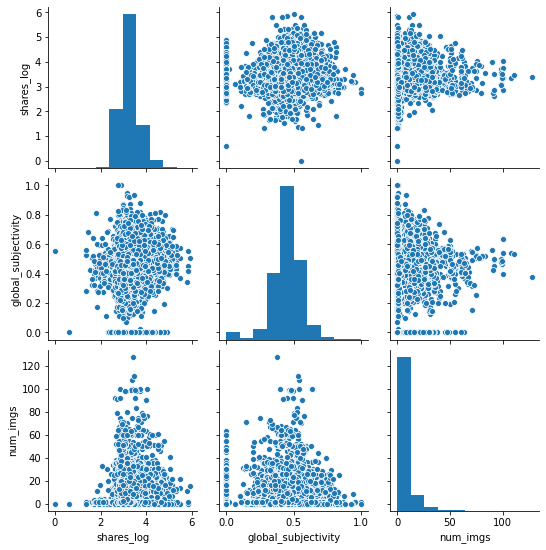

In [12]:
sns.pairplot(df_subset[["shares_log", "global_subjectivity", "num_imgs"]])
plt.show()

There are a number of articles with 0 scores for global_subjectivity. These are articles without text. Since this is not an error, we'll keep them in.

See the top row for the relations between the independent variables and the dependent. The relation between *global_subjectivity* and *shares_log* seems linear (no real curve) but is very weak (not visible to the eye). The relation between *num_imgs* and *shares_log* seems linear and slightly negative, but is also very weak .


Let's calculate the correlations again to check.

In [13]:
df_subset.corr().sort_values(by = "shares_log")

,shares_log,data_channel_is_world,data_channel_is_socmed,data_channel_is_entertainment,weekday_is_saturday,weekday_is_sunday,weekday_is_wednesday,weekday_is_thursday,weekday_is_tuesday,weekday_is_monday,global_subjectivity,num_imgs
data_channel_is_world,-0.141932,1.000000,-0.128047,-0.229642,0.000368,-0.008691,0.000024,0.004393,-0.012546,-0.004853,-0.198923,-0.106978
data_channel_is_entertainment,-0.080967,-0.229642,-0.118710,1.000000,-0.015870,0.007414,-0.005166,-0.011742,-0.000857,0.029317,0.027306,0.111108
weekday_is_wednesday,-0.032125,0.000024,-0.006285,-0.005166,-0.123538,-0.131253,1.000000,-0.229053,-0.228841,-0.215035,-0.011588,-0.026951
weekday_is_thursday,-0.030329,0.004393,0.016343,-0.011742,-0.122726,-0.130391,-0.229053,1.000000,-0.227336,-0.213621,-0.001215,-0.006894
weekday_is_tuesday,-0.027738,-0.012546,0.010562,-0.000857,-0.122613,-0.130270,-0.228841,-0.227336,1.000000,-0.213423,-0.002858,-0.002468
weekday_is_monday,-0.007843,-0.004853,-0.020112,0.029317,-0.115215,-0.122411,-0.215035,-0.213621,-0.213423,1.000000,-0.009050,-0.001395
weekday_is_sunday,0.071864,-0.008691,-0.011666,0.007414,-0.070326,1.000000,-0.131253,-0.130391,-0.130270,-0.122411,0.015468,0.044483
weekday_is_saturday,0.072644,0.000368,0.010063,-0.015870,1.000000,-0.070326,-0.123538,-0.122726,-0.122613,-0.115215,0.004367,0.027809
data_channel_is_socmed,0.085516,-0.128047,1.000000,-0.118710,0.010063,-0.011666,-0.006285,0.016343,0.010562,-0.020112,0.026838,-0.008554
num_imgs,0.085575,-0.106978,-0.008554,0.111108,0.027809,0.044483,-0.026951,-0.006894,-0.002468,-0.001395,0.069931,1.000000


All the correlations are weak. The relation between *num_imgs*/*global_subjectivity* and *shares_log* is actually positive. Looks can be deceiving with all these points on top of each other in the scatterplot.

## Fitting the model

We will split our data, train our model and then test it. Let's first create the *X* and *y* variables.

In [16]:
y = df_subset["shares_log"]
y.index = df_subset["url"] #set the label of each row to the url
X = df_subset.loc[:,"data_channel_is_world":"num_imgs"]
X.index = df_subset["url"]
X.head()

,data_channel_is_world,data_channel_is_socmed,data_channel_is_entertainment,weekday_is_saturday,weekday_is_sunday,weekday_is_wednesday,weekday_is_thursday,weekday_is_tuesday,weekday_is_monday,global_subjectivity,num_imgs
url,,,,,,,,,,,
http://mashable.com/2013/10/29/ashton-kutcher-lenovo/,0,0,0,0,0,0,0,1,0,0.439379,12
http://mashable.com/2014/09/08/mashies-sept-19-deadline/,1,0,0,0,0,0,0,0,1,0.300454,6
http://mashable.com/2013/02/01/hello-kitty-rocket/,0,0,0,0,0,0,0,0,0,0.575486,0
http://mashable.com/2014/02/06/add-us-on-snapchat/,0,0,0,0,0,0,1,0,0,0.327220,2
http://mashable.com/2014/01/07/lindsey-vonn-withdraws-sochi-olympics-knee-injury/,0,0,0,0,0,0,0,1,0,0.507709,18


The data will be split 70/30, 70% training set and 30% test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
X_train.head()

,data_channel_is_world,data_channel_is_socmed,data_channel_is_entertainment,weekday_is_saturday,weekday_is_sunday,weekday_is_wednesday,weekday_is_thursday,weekday_is_tuesday,weekday_is_monday,global_subjectivity,num_imgs
url,,,,,,,,,,,
http://mashable.com/2013/02/03/puppy-bowl-online/,0,0,0,0,1,0,0,0,0,0.451711,0
http://mashable.com/2014/09/11/bridesmaid-lost-dress-sydney/,0,0,0,0,0,0,1,0,0,0.476976,9
http://mashable.com/2013/03/08/facebook-acquires-storylane/,0,0,0,0,0,0,0,0,0,0.488495,1
http://mashable.com/2014/04/29/yahoo-mail-app-redesign/,0,0,0,0,0,1,0,0,0,0.545746,23
http://mashable.com/2013/08/28/chef-knife-moves-video/,0,0,0,0,0,1,0,0,0,0.507042,13


Now let's create the model and train it.

In [18]:
lm = LinearRegression()
model = lm.fit(X_train, y_train)

Now that the model is fitted, let's find the equation. First the intercept:

In [20]:
lm.intercept_

3.2002949000087355

And the slopes: 

In [22]:
pd.DataFrame(X.columns, lm.coef_) #make a DataFrame from coefficients and variable labels

,0
-0.150473,data_channel_is_world
0.080442,data_channel_is_socmed
-0.127570,data_channel_is_entertainment
0.108488,weekday_is_saturday
0.095767,weekday_is_sunday
-0.031477,weekday_is_wednesday
-0.039167,weekday_is_thursday
-0.032439,weekday_is_tuesday
-0.009612,weekday_is_monday
0.204268,global_subjectivity


Going from the general formula of $ y = b_0 + b_1x_1 + b_2x_2 + b_3x_3 .. b_nx_n + e$  the equation is as follows:

*log_shares* = 3.2 + 0.2043 *global_subjectivity* + 0.0036 *num_imgs* - 0.0096 *weekday_is_monday* - 0.0324 *weekday_is_tuesday* - 0.0315 *weekday_is_wednesday* - 0.0392 *weekday_is_thursday* + 0.1085 *weekday_is_saturday* + 0.0958 *weekday_is_sunday* - 0.1505 *data_channel_is_world* - 0.1276 *data_channel_is_entertainment* + *e*

## Evaluating the model

Now let's evaluate the model's performance. We'll start by calculating the residuals *e*.

In [24]:
y_test_p = lm.predict(X_test)
e = y_test - y_test_p
e

url
http://mashable.com/2013/04/06/creepy-petman-robot/                       0.143553
http://mashable.com/2014/07/08/nash-grier-vine-slur/                     -0.158282
http://mashable.com/2014/06/06/wwdc-2014-rise-of-the-kits/               -0.011063
http://mashable.com/2014/04/30/mario-kart-8-free-wii-u-game/              0.276601
http://mashable.com/2014/05/28/leaked-emails-evan-spiegel-snapchat/       0.558374
                                                                            ...   
http://mashable.com/2013/11/21/lady-gaga-tap-dance/                      -0.205782
http://mashable.com/2014/05/15/google-apps-message-encryption/           -0.146989
http://mashable.com/2014/04/22/apple-opens-up-os-x-betas-to-all-users/    0.563121
http://mashable.com/2013/06/10/samsung-galaxy-ace-3/                     -0.944667
http://mashable.com/2014/09/04/el-nino-later-weaker/                     -0.271502
Name: shares_log, Length: 7500, dtype: float64

Now we calculate the $ R^2 $ to see how well the model fits

In [25]:
y_test_p = lm.predict(X_test)
r2_score(y_test, y_test_p)

0.05456764624111543

$R^2$ is 0.0546, which means 5.46% of the variation in log shares can be explained by the model. Which is low, but this was to be expected given the low correlations between the variables.

Now we calculate the Root Mean Squared Error (RMSE).

In [28]:
math.sqrt(mean_squared_error(y_test, y_test_p))

0.3947980911357513

On average, we are by 0.39 off in our predictions of log shares.  

Let's plot the predictions to see where our model predicts best.

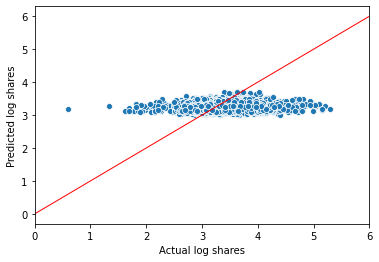

In [29]:
sns.scatterplot(y_test, y_test_p)
plt.xlabel('Actual log shares')
plt.ylabel('Predicted log shares')
plt.xlim([0,6]) #Forcing the x- and y-axis to be the same length, so that we can compare 
plt.plot([0,6], [0, 6], color='red', lw=1) #plot a diagonal length
plt.show()

The model overshoots for low number of shares and undershoots for high number of shares. In other words, its based mostly on the average number of log shares (~3) with little variation.

Finally, let's plot the residuals

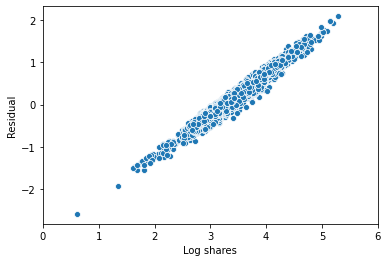

In [30]:
sns.scatterplot(y_test, e)
plt.xlabel('Log shares')
plt.ylabel('Residual')
plt.xlim([0,6]) #Forcing the x- and y-axis to be the same length, so that we can compare 
plt.show()

As could be predicted from the previous graph, the residuals are negative for low numbers of log shares (model overshoots) and positive for high numbers of log shares (model undershoots).

(In fact, this is just the same graph rotated 45 degrees).